In [1]:
colab = True

In [ ]:
if colab:
    import os
    from IPython.display import clear_output 
    !pip install node2vec
    !pip install scikit-multilearn
    clear_output()
    os.kill(os.getpid(), 9) 

### Traditional ML + Node2Vec

In [2]:
if colab: 
   from node2vec import Node2Vec

import pandas as pd
import networkx as nx
import numpy as np
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression


In [9]:
if colab:
    df = pd.read_csv('/content/berlin_edge_list.csv')
else:
    df = pd.read_csv('data/berlin/edge_list.csv')

In [10]:
df.head()

,from_stop_I,to_stop_I,label,d,n_vehicles
0,105,106,"[0, 0, 0, 1, 0]",233.0,159.0
1,105,107,"[0, 0, 0, 1, 0]",302.0,158.0
2,106,105,"[0, 0, 0, 1, 0]",233.0,158.0
3,106,117,"[0, 0, 0, 1, 0]",351.0,159.0
4,107,105,"[0, 0, 0, 1, 0]",302.0,159.0


In [11]:
G = nx.from_pandas_edgelist(df, source='from_stop_I', target='to_stop_I', create_using=nx.DiGraph(),
                            edge_attr='label')

In [12]:
values = nx.get_edge_attributes(G, "label")

In [13]:
targets = np.zeros(G.number_of_nodes())

In [14]:
np.zeros((G.number_of_edges(),5))

array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])

In [15]:
import ast 
def edge_target_extraction(G):

    values = nx.get_edge_attributes(G, "label")
    targets = np.zeros((G.number_of_edges(),5))
    for i,edge in enumerate(G.edges()):
        arr = np.array(ast.literal_eval(values[edge]))
        targets[i] = arr
    return targets



In [16]:
edge_target_extraction(G)

array([[0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       ...,
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.]])

In [17]:
betweeness_centrality = nx.edge_betweenness_centrality(G)

In [18]:
def average_operator(x, y):
  ''' 
  INPUT:
  x, y: pair of node features, each with dimension (D, ) (D: dimension of features) 
  
  OUTPUT:
  edge features by the operation on node features, with dimension (D, )
  '''
  return (x + y) / 2

In [19]:
def node_feature_extraction(G):
  '''
  INPUT:
  G: the graph

  OUTPUT:
  features: feature matrix of dimensions (N, D) (N: number of samples; D: number of features) 
  '''
# Your solution here ###########################################################
  team_to_idx = {team: i for i, team in enumerate(G.nodes())}
  features = np.zeros((G.number_of_nodes(), 5))

  closeness_centrality = nx.closeness_centrality(G)
  betweeness_centrality = nx.betweenness_centrality(G)
  eigenvector_centrality = nx.eigenvector_centrality(G,max_iter=500)

  for i,node in enumerate(G.nodes()):
    features[i, 0] = G.degree[node]
    features[i, 1] = nx.clustering(G, node)
    features[i, 2] = closeness_centrality[node]
    features[i, 3] = betweeness_centrality[node]
    features[i, 4] = eigenvector_centrality[node]
#^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  return features

#### Functions

In [20]:
def edge_feature_extraction(features_node,G):
    D = features_node.shape[1]
    features = np.zeros((G.number_of_edges(), D+1))
    node_to_idx = {node: i for i, node in enumerate(G.nodes())}
    for i, edge in enumerate(G.edges()):
        node_1 = node_to_idx[edge[0]]
        node_2 = node_to_idx[edge[1]]
        concat_array = np.concatenate((average_operator(features_node[node_1], features_node[node_2]),np.array([betweeness_centrality[edge]])))
        features[i] = concat_array
    
        #features[i, 2] = nx.closeness_centrality(G)[i]
        #features[i, 3] = nx.betweenness_centrality(G)[i]
        #features[i, 4] = nx.eigenvector_centrality(G)[i]
    return features

In [21]:
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif

from skmultilearn.model_selection import iterative_train_test_split

def classifier(features, targets, labels, feature_selection=False, num_features=1, test_size=0.5, seed=0, verbose=False):
  ''' 
  INPUT:
  features: feature matrix of dimensions (N, D) (N: number of samples; D: number of features) 
  targets: target vector of dimensions (N, ) (N: number of samples)
  labels: vector of all possible labels for nodes in the graph 
  feature_selection: a flag for whether to use feature selction, bool
  num_features: number of features used from feature selesction
  test_size: please set to 0.5 for reproducibility
  seed: please set to 0 for reproducibility
  verbose: print and plot result or not, bool
  
  OUTPUT:
  cm: confusion matrix on the test set
  f1: weighted f1 score on the test set

  ** Please set all of the random_state=seed in following module **
  '''

  # Split the data into training and testing sets, with test_size=0.5
  # Your solution here ###########################################################
  np.random.seed(seed)
  X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=test_size, random_state=seed, stratify=targets)
  #X_train, y_train, X_test, y_test = iterative_train_test_split(features, targets, test_size = test_size)
    #^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  if feature_selection:
    ## Your solution here ###########################################################
    ## Build and train the ML model, including feature selection, normalization and Support Vector Classifier. Select the k highest relevant features for the classification. 
    selector = SelectKBest(f_classif, k=num_features)
    X_train = selector.fit_transform(X_train, y_train)
    X_test = selector.transform(X_test)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    clf = svm.SVC(class_weight='balanced', random_state=seed)
    
    # Wrap the binary classifier in the MultiOutputClassifier for multi-label classification
    clf = MultiOutputClassifier(clf)
    clf.fit(X_train, y_train)
    
    ## Print the scores for individual features.
    if verbose:
      print(f"Scores for individual features: {selector.scores_}")

   
    ##^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  else:
    ## Your solution here ###########################################################
    ## Build and train the ML model, including normalization and Support Vector Classifier.
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    clf = svm.SVC(class_weight='balanced', random_state=seed)

    # Wrap the binary classifier in the MultiOutputClassifier for multi-label classification
    clf = MultiOutputClassifier(clf)
    clf.fit(X_train, y_train)

    ##^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  # Your solution here ###########################################################
  # Use the model to predict the labels of the test data
  y_pred = clf.predict(X_test)
  

  # Output the confusion matrix and weighted f1 score on the test set. Print the weighted f1 score and plot the confusion matrix if verbose
  #cm = metrics.confusion_matrix(y_test, y_pred, labels=labels)
  f1 = metrics.f1_score(y_test, y_pred, average='weighted')
  if verbose:
    print(f"Weighted f1 score: {f1}")
    #disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    #disp.plot()
  
  #^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  return f1,y_pred,y_test

In [22]:
def Node2Vec_node_feature_extraction(G, num_features=1, p=1.0, q=1.0, seed=0):
  ''' 
  INPUT:
  G: the graph
  num_features: dimension of node2vec embeddings, int
  p: float
  q: float
  seed: please always set to 0
  
  OUTPUT:
  features: feature matrix of dimensions (N, D) (N: number of samples; D: dimension of Node2Vec embeddings) 
  '''
  
  # 
  # Your solution here ###########################################################
  # Use Node2Vec to extract node embeddings
  np.random.seed(seed)

  #node2vec = Node2Vec(G, dimensions=num_features, p=p, q=q, seed=seed)
  node2vec = Node2Vec(G,dimensions=num_features, walk_length=20, p=1, q=1,seed=seed)
  #model = N

  #node2vec = Node2Vec(G, dimensions=num_features,workers=4)
  model = node2vec.fit(window=10, min_count=1, batch_words=4, seed=seed)
  embeddings = model.wv
  features  = np.zeros((G.number_of_nodes(), num_features))
  for i, node in enumerate(G.nodes()):
    if node in embeddings:
      features[i] = embeddings[node]
      print("embedding found")
    else:
      print("node embedding not found")
      features[i] = np.zeros(num_features)


  
  #^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  return features

#### Traditional features performance

In [23]:
targets = edge_target_extraction(G)
features_node = node_feature_extraction(G)

In [24]:
features_edge = edge_feature_extraction(features_node,G)

In [97]:
f1,y_pred,y_test = classifier(features_edge, targets, None, feature_selection=False, verbose=True)

Weighted f1 score: 0.7801487048786827


In [98]:
precision = metrics.precision_score(y_test, y_pred, average='weighted')
recall = metrics.recall_score(y_test, y_pred, average='weighted')
f1 = metrics.f1_score(y_test, y_pred, average='weighted')
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Precision: 0.8126110739614844
Recall: 0.8102649006622517
F1-score: 0.7801487048786827


In [27]:
#check which index has 1 and count how many times, in y_test
y_test.sum(axis=0)

array([4.960e+02, 1.820e+02, 2.540e+02, 5.104e+03, 4.000e+00])

In [29]:
y_pred.sum(axis=0)

array([2851., 1378.,  741., 4526.,  151.])

We obtained 0.80 of accuracy in predicting the transportation mode of an edge, and the prediction seem to be fairly balanced

#### Node2Vec on Colab

In [58]:
features_node2vec = Node2Vec_node_feature_extraction(G, num_features=128, p=0.5, q=10.0, seed=0)
features_edge_node2vec = edge_feature_extraction(features_node2vec, G)
f1,y_pred,y_test = classifier(features_edge_node2vec, targets, None, feature_selection=False, verbose=True)
#^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Weighted f1 score: 0.8899344839579202


In [59]:
precision = metrics.precision_score(y_test, y_pred, average='weighted')
recall = metrics.recall_score(y_test, y_pred, average='weighted')
f1 = metrics.f1_score(y_test, y_pred, average='weighted')
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Precision: 0.9030074195918979
Recall: 0.884271523178808
F1-score: 0.8899344839579202


In [34]:
#check which index has 1 and count how many times, in y_test
y_pred.sum(axis=0)

array([ 310.,  124.,  196., 5204., 1508.])

In [35]:
y_test.sum(axis=0)

array([4.960e+02, 1.820e+02, 2.540e+02, 5.104e+03, 4.000e+00])

## GNN on colab

In [1]:
!pip install torch==2.0.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import torch 

def format_pytorch_version(version):
  return version.split('+')[0]

TORCH_version = torch.__version__
TORCH = format_pytorch_version(TORCH_version)

def format_cuda_version(version):
  return 'cu' + version.replace('.', '')

CUDA_version = torch.version.cuda
CUDA = format_cuda_version(CUDA_version)

!pip install torch-scatter     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-sparse      -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-cluster     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-geometric

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-2.0.0+cu117.html
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-2.0.0+cu117.html
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-2.0.0+cu117.html
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-2.0.0+cu117.html
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
#####################################################
################## PACKAGES #########################
#####################################################
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch.nn as nn
import torch_geometric.nn as graphnn
from sklearn.metrics import f1_score
from torch_geometric.datasets import PPI
from torch_geometric.loader import DataLoader

In [23]:
import pandas as pd
import numpy as np
import torch
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from ast import literal_eval
import torch.nn.functional as F
from sklearn import metrics


In [5]:
import numpy as np
import torch
import random

def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

# Set seed for reproducibility
set_seed(42)


### Multiple graphs

In [6]:
import pandas as pd
import torch
import pandas as pd
from torch_geometric.data import Data, Batch
import os
import networkx as nx

def csv_to_data(edge_csv):
    # Read CSV file
    df = pd.read_csv(edge_csv)
    nodes = sorted(list(set(df['from_stop_I']).union(set(df['to_stop_I']))))
    node_mapping = {node: i for i, node in enumerate(nodes)}

    # Apply this mapping to the 'from_stop_I' and 'to_stop_I' columns
    df['from_stop_I'] = df['from_stop_I'].map(node_mapping)
    df['to_stop_I'] = df['to_stop_I'].map(node_mapping)

    edge_index = torch.tensor(df[["from_stop_I","to_stop_I"]].values, dtype=torch.long).t().contiguous()
    df['label'] = df['label'].apply(literal_eval)  # convert string format list to actual list
    y = torch.tensor(df["label"].tolist(), dtype=torch.float)
    edge_attr = torch.tensor(df["d"].values, dtype=torch.float).unsqueeze(1)  # edge attributes must have an extra dimension

    G = nx.DiGraph()
    G.add_nodes_from(nodes)  # Initialize all nodes
    G.add_edges_from(df[['from_stop_I', 'to_stop_I']].values)  # Add edges

    # Calculate node features for all nodes in the graph
    all_nodes = list(G.nodes)
    degree = dict(G.degree(all_nodes))
    #betweenness_centrality = nx.betweenness_centrality(G)
    #clustering_coefficient = nx.clustering(G)
    #closeness_centrality = nx.closeness_centrality(G)

    # Prepare a DataFrame with node features
    df_nodes = pd.DataFrame.from_dict([degree]).T
    df_nodes.columns = ['degree']
    nodes = np.array(nodes, dtype=np.int64)
    df_nodes = df_nodes.reindex(nodes)  # Ensure the node features are in the correct order


    x = torch.tensor(df_nodes.values, dtype=torch.float)

    # Create Data object
    data = Data(x=x, edge_index=edge_index, y=y, edge_attr=edge_attr) # Data(x=x,edge_index=edge_index,y=y,edge_attr=edge_attr)

    return data

# Use this function for every pair of csv files (edges and features) to create the data_list
list_of_edges_csv = []
for file_name in os.listdir("/content/processed_files"):
    file_path = os.path.join("/content/processed_files", file_name)
    # Check if the file is a CSV file
    if file_path.endswith('.csv'):
        list_of_edges_csv.append(file_path)

data_list = [csv_to_data(edge_csv) for edge_csv in list_of_edges_csv]


In [7]:
batch = Batch.from_data_list(data_list)
batch

DataBatch(x=[144276, 1], edge_index=[2, 180962], edge_attr=[180962, 1], y=[180962, 5], batch=[144276], ptr=[26])

In [8]:
from torch_geometric.data import Batch, Data

# Convert the batch back to a list of data objects
data_list = data_list

# Initialize lists for train, validation, and test data objects
train_data_list = []
valid_data_list = []
test_data_list = []

# Specify the ratios
train_ratio = 0.8
valid_ratio = 0.1
# Note: test_ratio = 0.1

# Perform train/validation/test split on each data object
for data in data_list:
    num_edges = data.edge_index.size(1)

    # Calculate the number of edges for train, validation, and test
    train_size = int(num_edges * train_ratio)
    valid_size = int(num_edges * valid_ratio)

    # Create a random permutation of indices
    perm = torch.randperm(num_edges)

    # Split the edge_index, edge_attr, y, etc. for training data
    train_data = Data(x=data.x,edge_index=data.edge_index[:, perm[:train_size]], edge_attr=data.edge_attr[perm[:train_size]], y=data.y[perm[:train_size]])
    train_data_list.append(train_data)

    # Split the edge_index, edge_attr, y, etc. for validation data
    valid_data = Data(x=data.x,edge_index=data.edge_index[:, perm[train_size:train_size+valid_size]], edge_attr=data.edge_attr[perm[train_size:train_size+valid_size]], y=data.y[perm[train_size:train_size+valid_size]])
    valid_data_list.append(valid_data)

    # Split the edge_index, edge_attr, y, etc. for test data
    test_data = Data(x=data.x,edge_index=data.edge_index[:, perm[train_size+valid_size:]], edge_attr=data.edge_attr[perm[train_size+valid_size:]], y=data.y[perm[train_size+valid_size:]])
    test_data_list.append(test_data)

# Convert the lists of data objects back to batches
train_batch = Batch.from_data_list(train_data_list)
valid_batch = Batch.from_data_list(valid_data_list)
test_batch = Batch.from_data_list(test_data_list)


In [9]:
print("Number of nodes in train batch:", train_batch.num_nodes)
print("Number of edges in train batch:", train_batch.num_edges)

print("Number of nodes in test batch:", test_batch.num_nodes)
print("Number of edges in test batch:", test_batch.num_edges)


Number of nodes in train batch: 144276
Number of edges in train batch: 144757
Number of nodes in test batch: 144276
Number of edges in test batch: 18121


In [10]:
train_batch

DataBatch(x=[144276, 1], edge_index=[2, 144757], edge_attr=[144757, 1], y=[144757, 5], batch=[144276], ptr=[26])

In [11]:
edge_labels_np = train_batch.y.cpu().numpy()

In [12]:
t = train_batch.y.sum(axis=0)
float_tensor = t.tolist()

# Print the numbers without exponential notation
formatted_numbers = [f'{num:.0f}' for num in float_tensor]
print(formatted_numbers)

['4163', '1272', '3572', '135866', '477']


In [13]:
import numpy as np
import torch

# Assume edge_labels is your one-hot encoded labels and edge_index is your edge pairs in train_batch
# Convert edge labels to numpy for easy manipulation
edge_labels_np = train_batch.y.cpu().numpy()

# This will hold the final balanced indices
balanced_indices = []

# Loop over each class
# Loop over each class
for class_idx in range(edge_labels_np.shape[1]):
    # Get indices of positive and negative samples for this class
    positive_indices = np.where(edge_labels_np[:, class_idx] == 1)[0]
    negative_indices = np.where(edge_labels_np[:, class_idx] == 0)[0]

    # If there's no positive samples for this class, we skip it
    if len(positive_indices) == 0:
        continue

    # Determine which set of indices is the majority
    majority_indices = positive_indices if len(positive_indices) > len(negative_indices) else negative_indices
    minority_indices = negative_indices if majority_indices is positive_indices else positive_indices

    # Downsample the majority class to have same number of samples as the minority class
    # Downsample class_idx 3 much more
    if class_idx == 3:
        downsampled_majority_indices = np.random.choice(majority_indices, len(minority_indices) // 2, replace=False)  # Downsample by half
    else:
        downsampled_majority_indices = np.random.choice(majority_indices, len(minority_indices), replace=False)

    # Combine the downsampled majority indices with the minority indices
    class_balanced_indices = np.concatenate((downsampled_majority_indices, minority_indices))

    # Add these indices to our final list of balanced indices
    balanced_indices.append(class_balanced_indices)

# Flatten the list of balanced indices and remove duplicates
balanced_indices = list(set(np.hstack(balanced_indices)))

# Convert balanced_indices back to a tensor
balanced_indices = torch.tensor(balanced_indices, dtype=torch.long)

# Get the balanced edge_index and edge_labels
train_batch.edge_index = train_batch.edge_index[:, balanced_indices]
train_batch.y = train_batch.y[balanced_indices]

# If there are other attributes such as edge_attr parallel to edge_index and edge_labels,
# don't forget to select the corresponding elements using balanced_indices.
# For example:
train_batch.edge_attr = train_batch.edge_attr[balanced_indices]


In [14]:
t = train_batch.y.sum(axis=0)
float_tensor = t.tolist()

# Print the numbers without exponential notation
formatted_numbers = [f'{num:.0f}' for num in float_tensor]
print(formatted_numbers)

['4163', '1272', '3572', '13571', '477']


In [15]:
print("Number of nodes in train batch:", train_batch.num_nodes)
print("Number of edges in train batch:", train_batch.num_edges)
print("Number of labels:",train_batch.y.size())

Number of nodes in train batch: 144276
Number of edges in train batch: 22462
Number of labels: torch.Size([22462, 5])


In [16]:
class GATGNN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GATGNN, self).__init__()
        self.gat1 = graphnn.GATConv(train_batch.x.size()[1], hidden_channels, heads=4)
        self.gat2 = graphnn.GATConv(hidden_channels*4, hidden_channels, heads=4)
        self.gat3 = graphnn.GATConv(hidden_channels*4, train_batch.y.size()[1], heads=6)

        self.linear = nn.Linear(train_batch.y.size()[1]*6,train_batch.y.size()[1])

        self.edge_classifier = nn.Linear(train_batch.y.size()[1]*2, train_batch.y.size()[1])

        self.elu = nn.ELU()

    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        x = self.gat1(x, edge_index,edge_attr)
        x = self.elu(x)
        x = self.gat2(x, edge_index,edge_attr)
        x = self.elu(x)
        x = self.gat3(x, edge_index,edge_attr)
        x = self.linear(x)
        
        # Generate edge features
        source_node_features = x[edge_index[0]]
        target_node_features = x[edge_index[1]]
        edge_features = torch.cat([source_node_features, target_node_features], dim=-1)

        # Edge-level prediction
        edge_out = self.edge_classifier(edge_features)
        return edge_out

In [17]:
class GNN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GNN, self).__init__()
        self.conv1 = GCNConv(train_batch.x.size()[1], hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.edge_classifier = torch.nn.Linear(hidden_channels*2, train_batch.y.size()[1])  # Predicts edge attributes


    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        
        # Generate edge features
        source_node_features = x[edge_index[0]]
        target_node_features = x[edge_index[1]]
        edge_features = torch.cat([source_node_features, target_node_features], dim=-1)

        # Edge-level prediction
        edge_out = self.edge_classifier(edge_features)
        return edge_out

In [18]:
def train(model):
    model.train()
    optimizer.zero_grad()
    out = model(train_batch)
    loss = criterion(out, train_batch.y)
    loss.backward()
    optimizer.step()
    return loss.item()

In [19]:
import matplotlib.pyplot as plt

def plot_losses(losses,valid_losses,f1_scores,model_name):
  plt.figure(figsize=(12, 6))

  # Plot losses
  plt.subplot(1, 2, 1)
  plt.plot(losses, label='Train Loss')
  plt.plot(valid_losses, label='Validation Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('Loss vs. Epoch')
  plt.legend()

  # Plot F1 scores
  plt.subplot(1, 2, 2)
  plt.plot(f1_scores, label='F1 Score')
  plt.xlabel('Epoch')
  plt.ylabel('F1 Score')
  plt.title('F1 Score vs. Epoch')
  plt.legend()

  plt.tight_layout()
  plt.savefig(f"{model_name}_plots")
  plt.show()

In [28]:
def train_all(model,lr=0.002,epochs=50):
  optimizer = torch.optim.Adam(model.parameters(),lr=lr)#,weight_decay=5e-4)#optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
  criterion = torch.nn.BCEWithLogitsLoss()

  # Lists to store losses and f1 scores
  train_losses = []
  valid_losses = []
  f1_scores = []

  for epoch in range(epochs):
      model.train()
      optimizer.zero_grad()
      out = model(train_batch)
      loss = criterion(out, train_batch.y)
      loss.backward()
      optimizer.step()
      train_losses.append(loss.item())

      # Evaluation phase
      model.eval()

      # Make predictions on the test set
      with torch.no_grad():
          valid_out = model(valid_batch)
          valid_loss = criterion(valid_out, valid_batch.y)
          valid_losses.append(valid_loss.item())
          
           # Make predictions on the test set
          test_pred = model(test_batch)
          test_pred = (torch.sigmoid(test_pred) > 0.5).float()

          # Calculate the F1 score
          f1 = f1_score(test_batch.y.numpy(), test_pred.numpy(), average='micro')
          f1_scores.append(f1)

      print(f"Epoch: {epoch+1}, Train Loss: {loss}, Validation Loss: {valid_loss}, F1 Score: {f1}")

  precision = metrics.precision_score(test_batch.y.numpy(), test_pred.numpy(), average='micro')
  recall = metrics.recall_score(test_batch.y.numpy(), test_pred.numpy(), average='micro')
  f1 = metrics.f1_score(test_batch.y.numpy(), test_pred.numpy(), average='micro')
  print("Precision:", precision)
  print("Recall:", recall)
  print("F1-score:", f1)

  predicted_labels = test_pred.numpy()
  counts = np.sum(predicted_labels, axis=0)

    # Assuming test_pred is your model's predictions and they are already binarized
  predicted_labels = test_pred.numpy()

  # Sum along the sample axis to get count of predictions for each class
  counts = np.sum(predicted_labels, axis=0)

  for i, count in enumerate(counts):
      print(f"Class {i} is predicted {count} times.")

  plot_losses(train_losses, valid_losses, f1_scores,type(model).__name__)


Epoch: 1, Train Loss: 0.6812658309936523, Validation Loss: 0.6669661402702332, F1 Score: 0.7644968827512234
Epoch: 2, Train Loss: 0.6776957511901855, Validation Loss: 0.6616723537445068, F1 Score: 0.8277110178080208
Epoch: 3, Train Loss: 0.6731175780296326, Validation Loss: 0.6562018990516663, F1 Score: 0.8381686089034082
Epoch: 4, Train Loss: 0.6693342924118042, Validation Loss: 0.6504135131835938, F1 Score: 0.840863576417721
Epoch: 5, Train Loss: 0.6657223701477051, Validation Loss: 0.6443873643875122, F1 Score: 0.8436367198981093
Epoch: 6, Train Loss: 0.6619887351989746, Validation Loss: 0.6382050514221191, F1 Score: 0.8446775656266085
Epoch: 7, Train Loss: 0.6574957966804504, Validation Loss: 0.6317769885063171, F1 Score: 0.8549644861669895
Epoch: 8, Train Loss: 0.6538910865783691, Validation Loss: 0.6250922083854675, F1 Score: 0.8559996023461576
Epoch: 9, Train Loss: 0.6487621665000916, Validation Loss: 0.6181420087814331, F1 Score: 0.8614183474300585
Epoch: 10, Train Loss: 0.6444

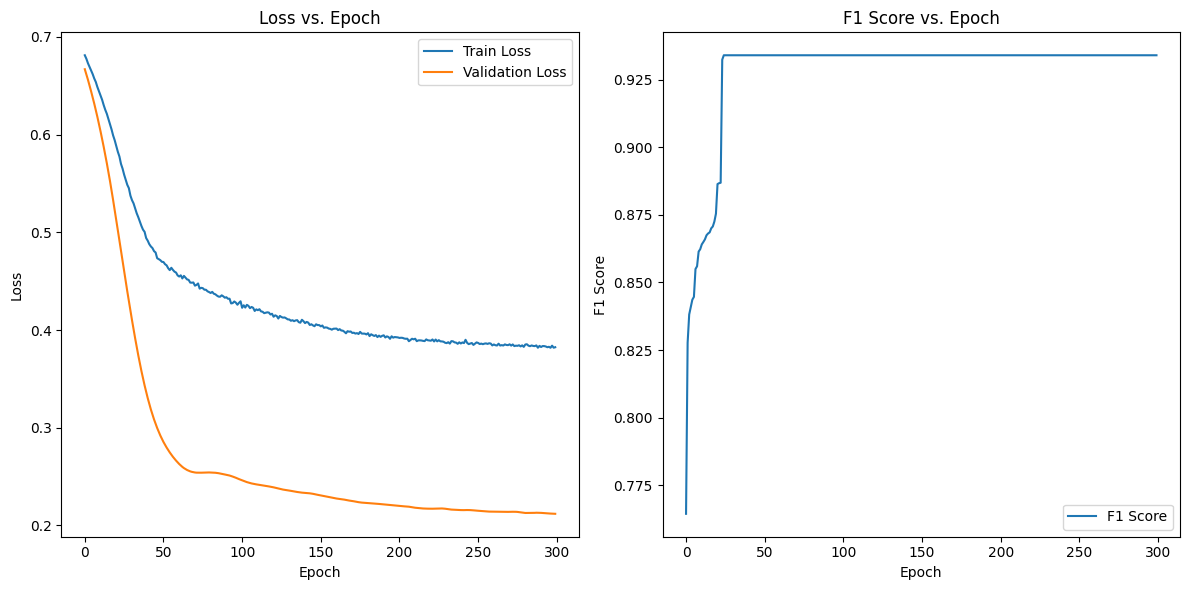

In [32]:
#gnn
model = GNN(hidden_channels=16)
lr = 0.002
train_all(model,lr,300)

Epoch: 1, Train Loss: 0.6601004600524902, Validation Loss: 0.3275357782840729, F1 Score: 0.8424640974807796
Epoch: 2, Train Loss: 0.6001684665679932, Validation Loss: 0.36497241258621216, F1 Score: 0.6191765507362831
Epoch: 3, Train Loss: 0.5514662861824036, Validation Loss: 0.48473358154296875, F1 Score: 0.6121062703653259
Epoch: 4, Train Loss: 0.5574376583099365, Validation Loss: 0.37017521262168884, F1 Score: 0.8687184661957619
Epoch: 5, Train Loss: 0.5052633881568909, Validation Loss: 0.2834283411502838, F1 Score: 0.9339869461044862
Epoch: 6, Train Loss: 0.4961181879043579, Validation Loss: 0.2570036053657532, F1 Score: 0.9339869461044862
Epoch: 7, Train Loss: 0.4931585192680359, Validation Loss: 0.25837427377700806, F1 Score: 0.9339869461044862
Epoch: 8, Train Loss: 0.4690362513065338, Validation Loss: 0.2772075831890106, F1 Score: 0.9338583544443221
Epoch: 9, Train Loss: 0.4434288740158081, Validation Loss: 0.29242029786109924, F1 Score: 0.9332416070445789
Epoch: 10, Train Loss: 

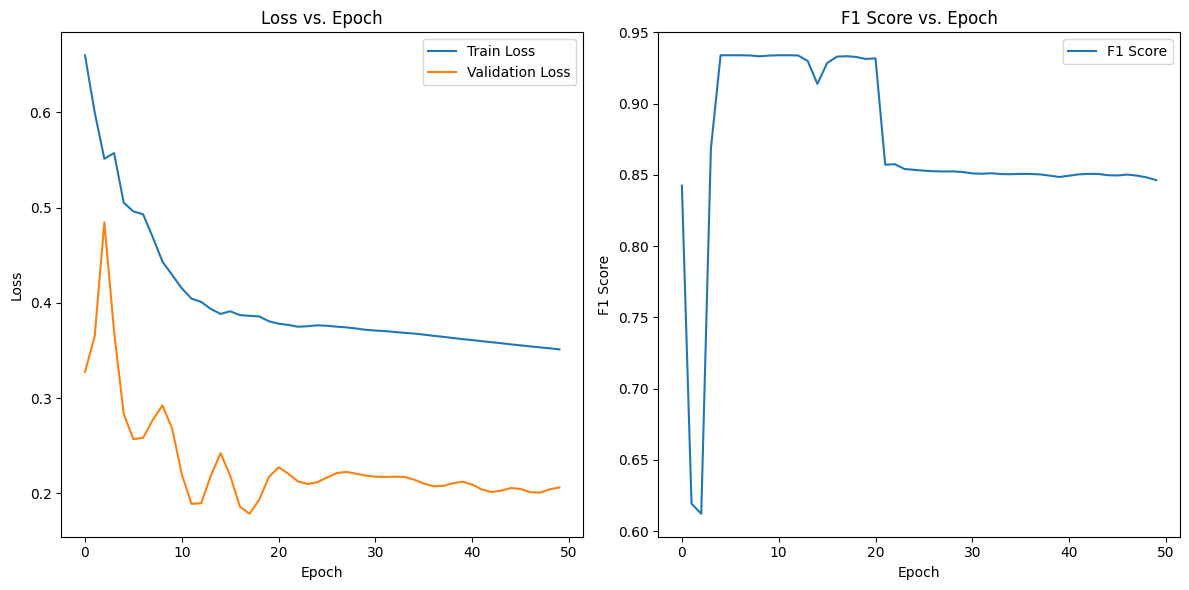

In [29]:
#gat
model = GATGNN(hidden_channels=128)
lr = 0.005

train_all(model,lr,epochs=50)

In [31]:
test_batch.y.sum(axis=0)

tensor([  531.,   155.,   470., 16957.,    77.])

### Single graph

#### Prepare dataset

In [ ]:
df = pd.read_csv("/content/edge_list.csv")
df.rename(columns={'value': 'edge_label'}, inplace=True)

In [ ]:
df.head()

,from_stop_I,to_stop_I,route_type,edge_label
0,105,106,[3],"[0, 0, 0, 1]"
1,105,107,[3],"[0, 0, 0, 1]"
2,106,105,[3],"[0, 0, 0, 1]"
3,106,117,[3],"[0, 0, 0, 1]"
4,107,105,[3],"[0, 0, 0, 1]"


In [ ]:
df['edge_label'] = df['edge_label'].apply(literal_eval)  # convert string format list to actual list
edge_label = torch.tensor(df['edge_label'].tolist(), dtype=torch.float)
edge_index = torch.tensor(df[['from_stop_I', 'to_stop_I']].values, dtype=torch.long).t().contiguous()


#### Node features

In [ ]:
# Create a graph using NetworkX
G = nx.from_pandas_edgelist(df, 'from_stop_I', 'to_stop_I', create_using=nx.DiGraph())

# Calculate node features for all nodes in the graph
all_nodes = list(G.nodes)
degree = dict(G.degree(all_nodes))
betweenness_centrality = nx.betweenness_centrality(G)

clustering_coefficient = nx.clustering(G)
closeness_centrality = nx.closeness_centrality(G)

# Prepare a DataFrame with node features
df_nodes = pd.DataFrame.from_dict([degree, betweenness_centrality, clustering_coefficient, closeness_centrality]).T
df_nodes.columns = ['degree', 'betweenness_centrality', 'clustering_coefficient', 'closeness_centrality']

In [ ]:
# Map node names to consecutive integers
mapping = {node: i for i, node in enumerate(df_nodes.index)}

In [ ]:
df['from_stop_I'] = df['from_stop_I'].map(mapping)
df['to_stop_I'] = df['to_stop_I'].map(mapping)


#### Train split and prepare data

In [ ]:
# Convert the DataFrame to a tensor
x = torch.tensor(df_nodes.values, dtype=torch.float)

# Create edge index tensor
edge_index = torch.tensor(df[['from_stop_I', 'to_stop_I']].values, dtype=torch.long).t().contiguous()

# Split edge indices and labels into train and test sets
edge_index_train, edge_index_test, edge_label_train, edge_label_test = train_test_split(
    edge_index.T, edge_label, test_size=0.2, random_state=42,stratify = edge_label)

# Convert train and test datasets back to PyTorch Geometric data format
train_data = Data(x=x, edge_index=edge_index_train.T.contiguous(), edge_attr=edge_label_train)
test_data = Data(x=x, edge_index=edge_index_test.T.contiguous(), edge_attr=edge_label_test)

In [ ]:
test_data.edge_attr.numpy().sum(axis=0)

array([ 198.,   73.,  101., 2042.], dtype=float32)

#### Train

In [ ]:
class GATGNN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GATGNN, self).__init__()
        self.gat1 = graphnn.GATConv(df_nodes.shape[1], hidden_channels, heads=4)
        self.gat2 = graphnn.GATConv(hidden_channels*4, hidden_channels, heads=4)
        self.gat3 = graphnn.GATConv(hidden_channels*4, len(edge_label[0]), heads=6)

        self.linear = nn.Linear(len(edge_label[0])*6,len(edge_label[0]))

        self.elu = nn.ELU()

    def forward(self, x, edge_index):
        x = self.gat1(x, edge_index)
        x = self.elu(x)
        x = self.gat2(x, edge_index)
        x = self.elu(x)
        x = self.gat3(x, edge_index)
        x = self.linear(x)
        return x

In [ ]:
class GNN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GNN, self).__init__()
        self.conv1 = GCNConv(df_nodes.shape[1], hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, len(edge_label[0]))

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv3(x, edge_index)
        return x


In [ ]:
model = GNN(hidden_channels=16)
optimizer = torch.optim.Adam(model.parameters(),lr=0.002)
criterion = torch.nn.BCEWithLogitsLoss()

In [ ]:
#model = GATGNN(hidden_channels=256)
#optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
#criterion = torch.nn.BCEWithLogitsLoss()

In [ ]:
def train():
    model.train()
    optimizer.zero_grad()
    out = model(train_data.x, train_data.edge_index)
    loss = criterion(out[train_data.edge_index[0]], train_data.edge_attr)
    loss.backward()
    optimizer.step()
    return loss.item()


In [ ]:
torch.unique(test_data.edge_index[0]).size()

torch.Size([1888])

In [ ]:
# Lists to store losses and f1 scores
losses = []
f1_scores = []

for epoch in range(100):
    loss = train()
    losses.append(loss)

    # Evaluation phase
    model.eval()

    # Make predictions on the test set
    with torch.no_grad():
        test_pred = model(test_data.x, test_data.edge_index)

    # Apply a sigmoid function to the predictions and round to get binary predictions

    print(test_pred)
    print(test_data.edge_index)
    print(test_data.edge_index[0])
    print(test_pred[test_data.edge_index[0]])
    break

    # test_pred are logits
    # test_data.edge_index[0] are the starting nodes of edges
    # test_pred[test_data.edge_index[0]] simply reorders the indexes so that,
    # they are aligned the same way as test_data.edge_attr

    test_pred = (torch.sigmoid(test_pred[test_data.edge_index[0]]) > 0.5).float()

    # Calculate the F1 score
    f1 = f1_score(test_data.edge_attr.numpy(), test_pred.numpy(), average='micro')
    f1_scores.append(f1)

    print(f"Epoch: {epoch+1}, Loss: {loss}, F1 Score: {f1}")


ValueError: ignored

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Plot losses
plt.subplot(1, 2, 1)
plt.plot(losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epoch')
plt.legend()

# Plot F1 scores
plt.subplot(1, 2, 2)
plt.plot(f1_scores, label='F1 Score')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.title('F1 Score vs. Epoch')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np

# Assuming test_pred is your model's predictions and they are already binarized
predicted_labels = test_pred.numpy()

# Sum along the sample axis to get count of predictions for each class
counts = np.sum(predicted_labels, axis=0)

for i, count in enumerate(counts):
    print(f"Class {i} is predicted {count} times.")

Class 0 is predicted 0.0 times.
Class 1 is predicted 0.0 times.
Class 2 is predicted 0.0 times.
Class 3 is predicted 2320.0 times.


Performance of GNN very similar to GAT, achieving 0.86. The problem is that because of class unbalanceness, the model will fit to predict always class 3. Adapting learning rate is not helping.